# cali

In [1]:
from utils import reader_csv, get_exp_info, gaus_fit, edep_plot,extract
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import utils
from scipy.interpolate import griddata
import json
import lmfit
Energy = [1,2,5,10,50,100] # GeV
num = 1000
path = [f"./data/B4_{e}_1000.csv" for e in Energy]
edep = np.zeros(len(Energy), dtype=np.float64)
sig = np.zeros(len(Energy), dtype=np.float64)
energys = np.zeros((len(Energy), num), dtype=np.float64)
center = np.zeros(len(Energy), dtype=np.float64)
sigma = np.zeros(len(Energy), dtype=np.float64)
position = np.zeros((len(Energy), num, 2), dtype=np.float64)
cali_result = {}
# raw data proess and fit
for i,(e, p) in enumerate(zip(Energy, path)):
    egap, labs, lgap, lsen, eSen, eAbs = reader_csv(p)
    energys[i,:], position[i] = get_exp_info(eSen*1e-3)
    mu, s = gaus_fit(energys[i,:])
    edep[i], sig[i] = mu, s
p = np.polyfit(edep,Energy, 1, w=1./sig)
cali_result['ec'] = {
    "slope": p[0],
    "intercept": p[1]}
# corr raw data with ec linear relationship
energys_corr = np.polyval(p, energys)
for i,e in enumerate(Energy):
    energy_cur = energys_corr[i,:]
    mu, s = gaus_fit(energy_cur)
    center[i], sigma[i] = mu, s


In [2]:
cali_result = {}
# raw data proess and fit
for i,(e, p) in enumerate(zip(Energy, path)):
    egap, labs, lgap, lsen, eSen, eAbs = reader_csv(p)
    energys[i,:], position[i] = get_exp_info(eSen*1e-3)
    mu, s = gaus_fit(energys[i,:])
    edep[i], sig[i] = mu, s
p = np.polyfit(edep,Energy, 1, w=1./sig)
cali_result['ec'] = {
    "slope": p[0],
    "intercept": p[1]}
# corr raw data with ec linear relationship
energys_corr = np.polyval(p, energys)
for i,e in enumerate(Energy):
    energy_cur = energys_corr[i,:]
    mu, s = gaus_fit(energy_cur)
    center[i], sigma[i] = mu, s


Text(0.5, 1.0, '100GeV; energy deposit distribusion in Si')

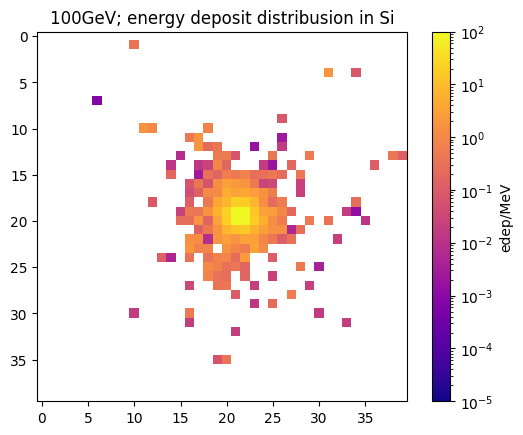

In [3]:
ax = plt.subplot()
norm = LogNorm(1e-5, 1e2)
h = edep_plot(eSen[100], ax=ax,norm=norm)
colorbar = plt.colorbar(h)
colorbar.set_label("edep/MeV")
ax.set_title(f"{Energy[-1]}GeV; energy deposit distribusion in Si")

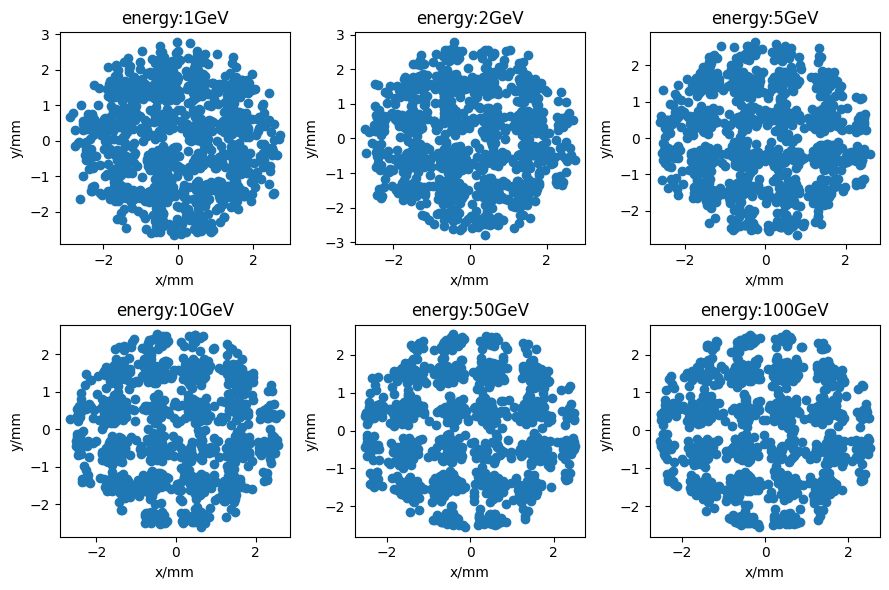

In [4]:
# plot scatter of pos for each energy
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
axs = axs.flatten()
for i,e in enumerate(Energy):
    ax = axs[i]
    ax.set_title(f"energy:{e}GeV")
    axs[i].set_xlabel('x/mm')
    axs[i].set_ylabel('y/mm')
    ax.scatter(position[i,:,0], position[i,:,1])
plt.tight_layout()


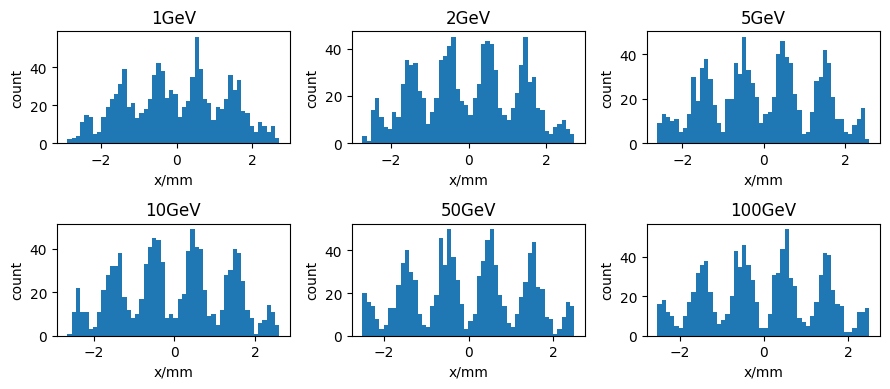

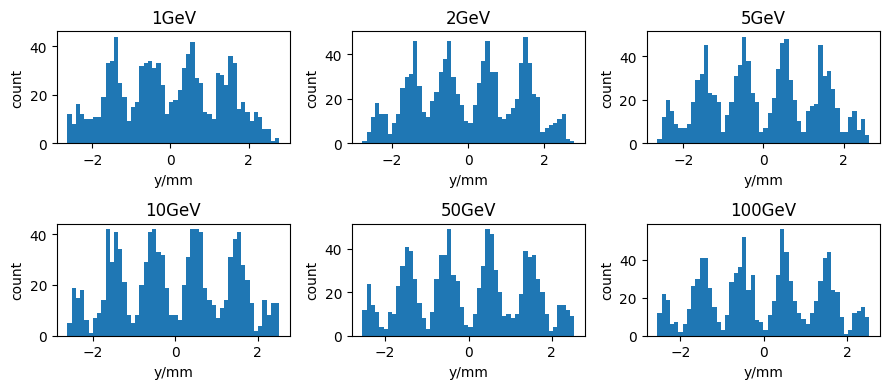

In [5]:
def pos_gaus(pos):
    h,bins = np.histogram(pos, bins=50)
    x = 0.5*(bins[1:]+bins[:-1])
    mod = lmfit.models.GaussianModel()
    pars = mod.make_params(amplitude=h.max(), mean=0, stddev=1)
    out = mod.fit(h, pars, x=x)
    return out
fig,axs = plt.subplots(2,3,figsize=(9,4))
axs = axs.flatten()
for i,e in enumerate(Energy):
    # out1 = pos_gaus(position[i,:,0])
    # out2 = pos_gaus(position[i,:,1])
    # out1.plot_fit(axs[i])
    # out2.plot_fit(axs[i+6])
    axs[i].hist(position[i,:,0],bins=50)
    axs[i].set_xlabel('x/mm')
    axs[i].set_ylabel('count')
    axs[i].set_title(f'{e}GeV')
plt.tight_layout()
plt.show()
fig,axs = plt.subplots(2,3,figsize=(9,4))
axs = axs.flatten()
for i,e in enumerate(Energy):
    # out1 = pos_gaus(position[i,:,0])
    # out2 = pos_gaus(position[i,:,1])
    # out1.plot_fit(axs[i])
    # out2.plot_fit(axs[i+6])
    axs[i].hist(position[i,:,1],bins=50)
    axs[i].set_xlabel('y/mm')
    axs[i].set_ylabel('count')
    axs[i].set_title(f'{e}GeV')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Energy calibration')

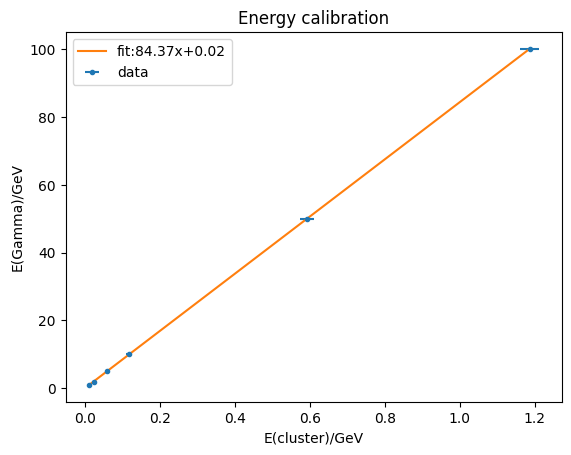

In [6]:
fig,ax = plt.subplots()
ax.errorbar(edep,Energy, xerr=sig, fmt='.', label="data")
ax.plot(edep, np.polyval(p, edep), label=f"fit:{p[0]:.2f}x+{p[1]:.2f}")
ax.legend()
ax.set_xlabel("E(cluster)/GeV")
ax.set_ylabel("E(Gamma)/GeV")
ax.set_title("Energy calibration")

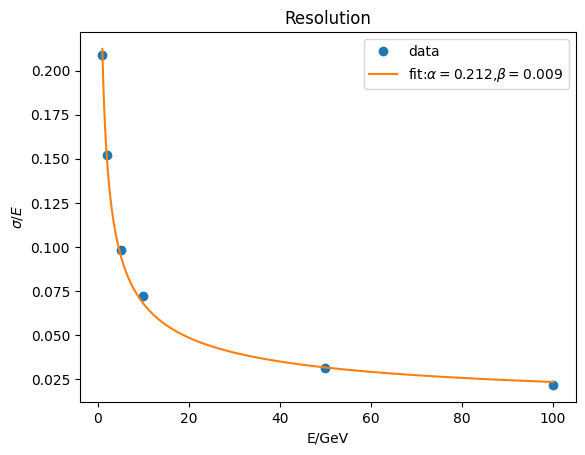

In [7]:
fig,ax = plt.subplots()
a,b = utils.res_fit(sigma,center,ax=ax)
ax.set_xlabel("E/GeV")
ax.set_ylabel("$\\sigma/E$")
ax.set_title("Resolution")
ax.legend(['data',f'fit:$\\alpha={a:.3f}$,$\\beta={b:.3f}$'])
cali_result['res'] = {
    "a": a,
    "b": b}
with open('./data/cali_result.json', 'w') as f:
    json.dump(cali_result, f)

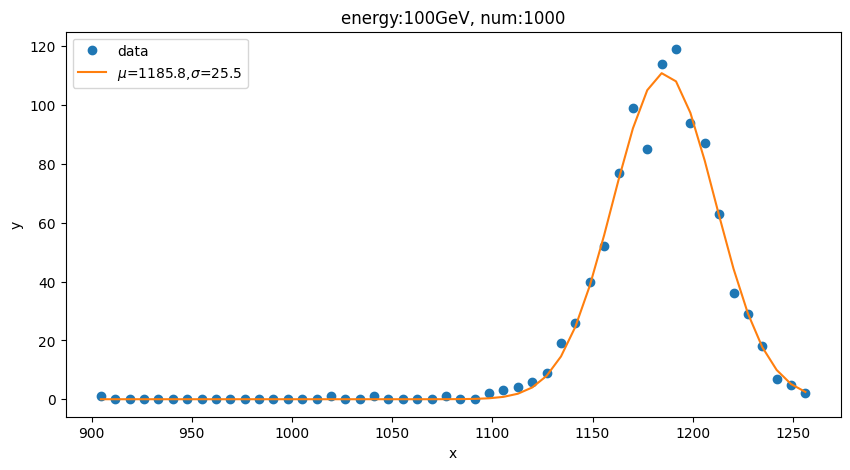

In [8]:
path = "./data/B4_100_1000.csv"
energy, num = extract(path)
egap, labs, lgap, lsen, eSen, eAbs = reader_csv(path)
energys, pos = get_exp_info(eSen)
fig, ax= plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(f"energy:{energy}GeV, num:{num}")
mu, sigma = gaus_fit(energys, ax)
ax.legend(["data",f"$\\mu$={mu:.1f},$\\sigma$={sigma:.1f}"])